<a href="https://colab.research.google.com/github/Tomas-Pompa/Data-science/blob/main/03_Finetuning_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Finetuning and transfer learning

Transfer learning - we use some pre-trained model and adjust it for our problem

In [ ]:
!pip install timm

In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## ConvNeXt


In [4]:
model_name = "convnext_tiny.fb_in22k"
convnext = timm.create_model(model_name, pretrained=True).to(device)

## Our custom dataset - Czech coins


---



In [5]:
DATASET = 'janstol/czech-coins'
ZIP_PATH = './czech-coins.zip'
IMAGES_PATH = './czech-coins-unzip'

In [6]:
os.environ['KAGGLE_USERNAME'] = 'tomaspompa'
os.environ['KAGGLE_KEY'] = '1829b8348bfae740f7dc3f8765038e7b'

!kaggle datasets download -d {DATASET} -p ./

 99% 110M/111M [00:02<00:00, 65.7MB/s]
100% 111M/111M [00:02<00:00, 44.9MB/s]


In [7]:
import zipfile

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./czech-coins-unzip/')

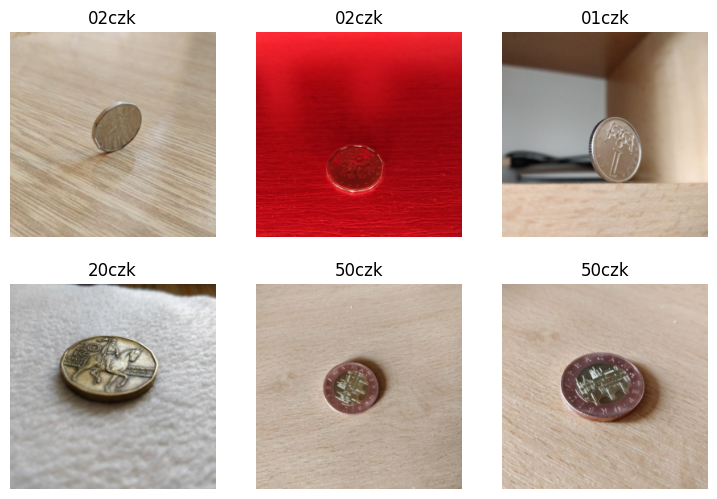

In [8]:
images = DataBlock( # preprocess the data from files
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split dataset into train and test
    get_y=parent_label,
    item_tfms=Resize(256, method='squish')) # transform images

dls = images.dataloaders(IMAGES_PATH, bs=64) # split into batches

dls.show_batch(max_n=6)

In [9]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

1503
375


## Load ConvNeXt model and fine-tune it

In [10]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(5, freeze_epochs=1) # first epoch is a special one

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:02<00:00, 39.9MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.018594,0.839135,0.717333,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.761343,0.489862,0.832000,01:11
1,0.579362,0.314449,0.888000,01:08
2,0.428944,0.207549,0.928000,01:11
3,0.310847,0.195853,0.938667,01:08
4,0.249849,0.192628,0.936000,01:07


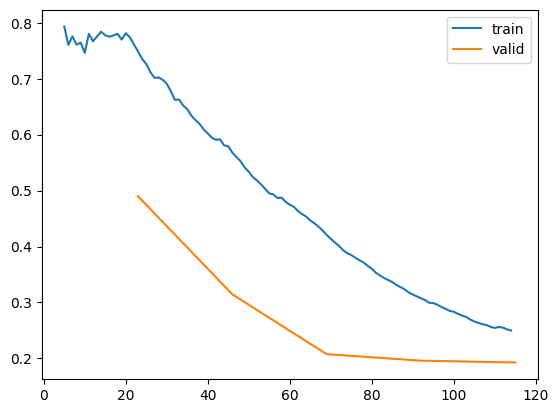

In [11]:
learn.recorder.plot_loss()

## See how our model performs:


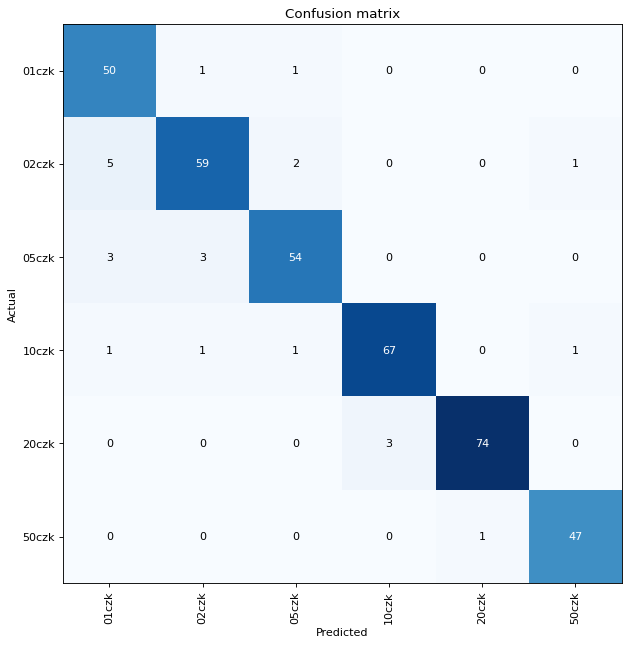

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### what is hard to predic?

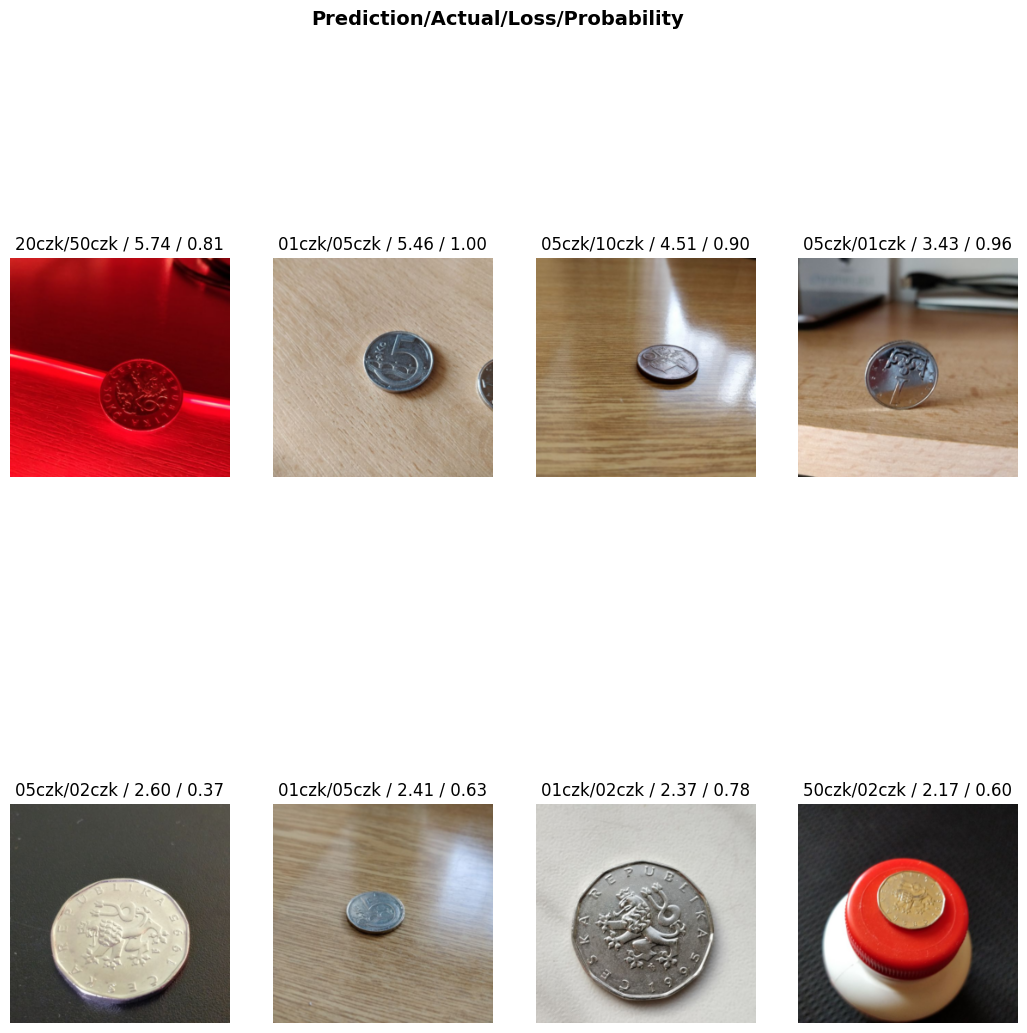

In [13]:
interp.plot_top_losses(8, figsize=(13,13))

## Data augmentation

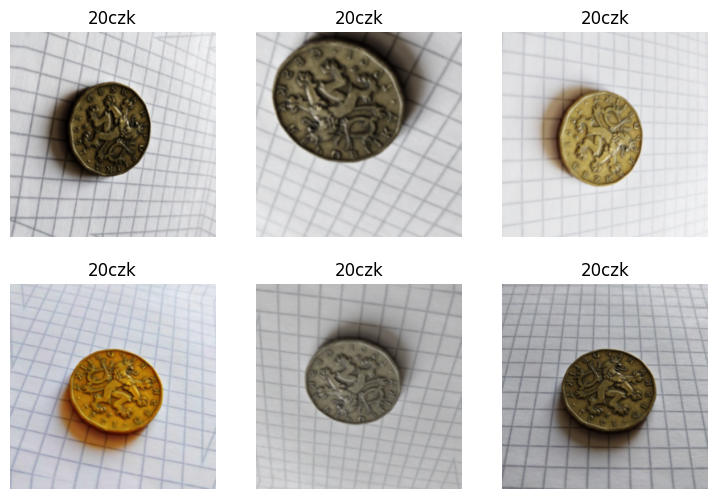

In [16]:
tfms = [Rotate(max_deg = 180), Zoom(max_zoom=1.5),
        Brightness(max_lighting=0.4),
        Contrast(max_lighting=0.4), FlipItem(), Flip(),
        Saturation(max_lighting=0.7)]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms # which transformations should be applied
).dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6, unique=True)

In [17]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(10, freeze_epochs=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.337872,1.060787,0.640000,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.133628,0.692429,0.728000,01:11
1,1.036798,0.523168,0.816000,01:07
2,0.861722,0.305545,0.890667,01:08
3,0.693521,0.256656,0.909333,01:08
4,0.558645,0.204927,0.936000,01:09
5,0.465112,0.177954,0.952000,01:07
6,0.382970,0.167617,0.954667,01:08
7,0.326950,0.146134,0.949333,01:08
8,0.294339,0.142937,0.949333,01:09
9,0.271272,0.146554,0.949333,01:07


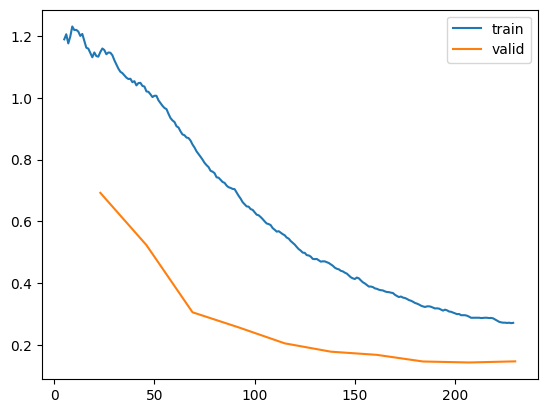

In [18]:
learn.recorder.plot_loss()

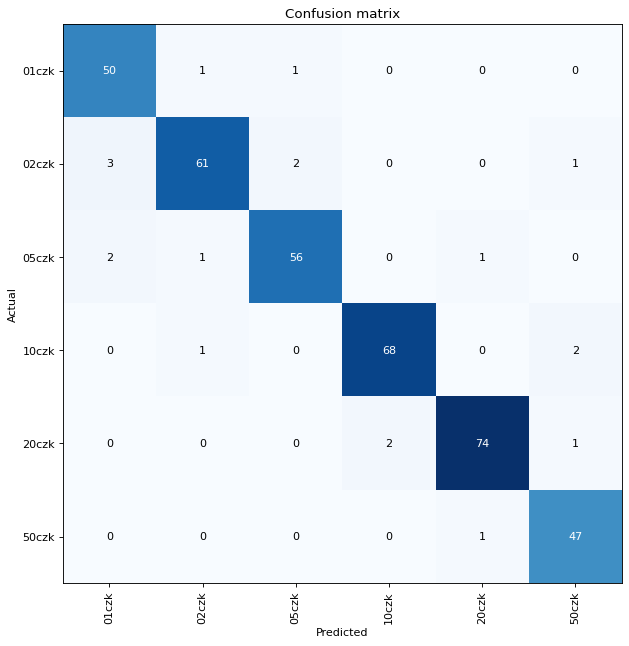

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

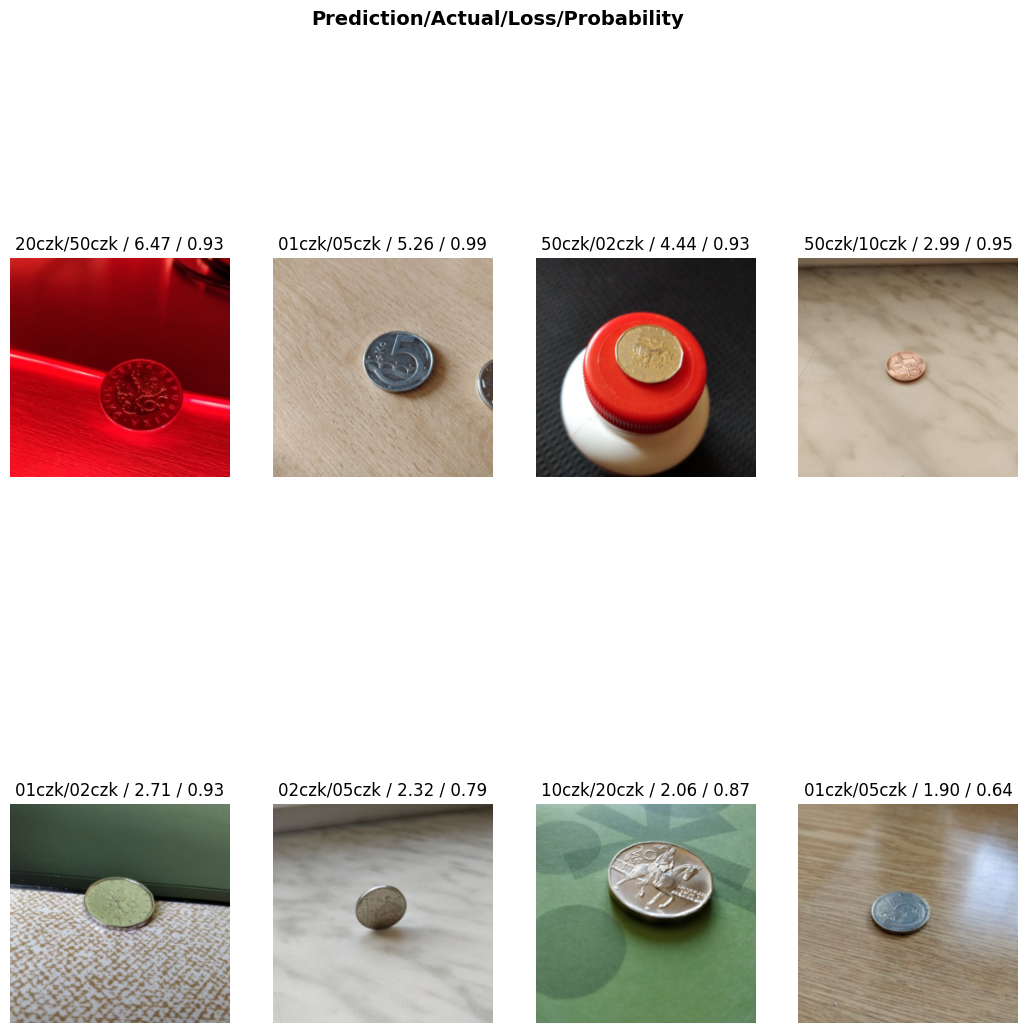

In [20]:
interp.plot_top_losses(8, figsize=(13,13))